#**Bases de datos orientadas a Grafos - Neo4j**
#Maestría en "Analítica de datos"


*   Nombre: Juan Carlos Díaz
*   fecha: 2025- 10 - 16
---

1.  NODOS
*   (n) => un nodo cualquiera
*   (:Persona) => un nodo con etiquieta Persona
*   (:Persona {nombre:'Luis'}) => un nodo con la propiedad "nombre" que sea igual a "Luis"
2.  REPRESENTACIONES


*   -[r]- => una relación cualquiera
*   -[:TRABAJA_EN]- => una relación de tipo "TRABAJA_EN"
*   -[:AMIGO_DE]- => una relación de tipo "AMIGO_DE"
*   <-[:COMPRO]- =>  una relación entrante de tipo "COMPRO"
3.  PATRONES DE CONSULTA
*  MATCH (a:Persona)-[:AMIGO_DE]->(b:Persona) RETURN a, b








#**0. Instalar librerías**

In [1]:
!pip install neo4j pandas matplotlib networkx pyvis -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.8/325.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.7 MB/s eta 0:00:00


#**1. Instanciar liberías**

In [2]:
import pandas as pd
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML

#**2. Configurar la conexión con NEO4J**

Se establecen los parámetros de conexión (URI, usuario, contraseña) para acceder a la base de datos Neo4j.

In [3]:
NEO4J_URI="neo4j+s://b19c9b54.databases.neo4j.io"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="0NFxQQEhx0lqq4qLmN9zzPFhEYhFhYqotMUuGWZm-IM"
NEO4J_DATABASE="neo4j"

In [4]:
# Clase para manejar la conexión con una base de datos Neo4j mediante el driver oficial
class Neo4jConnection:
    def __init__(self, uri, user, password, database):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))  # Crea el driver de conexión con Neo4j
        self.database = database                                        # Guarda el nombre de la base de datos a usar

    def close(self):
        self.driver.close()                                             # Cierra la conexión con el servidor Neo4j

    def query(self, query, parameters=None):
        # Ejecuta una consulta (por ejemplo MATCH o RETURN) y devuelve los resultados como lista
        with self.driver.session(database=self.database) as session:    # Abre una sesión en la base de datos
            result = session.run(query, parameters)                     # Ejecuta la consulta Cypher
            return [record for record in result]                        # Devuelve los registros obtenidos

    def execute(self, query, parameters=None):
        # Ejecuta una consulta sin devolver resultados (por ejemplo CREATE o DELETE)
        with self.driver.session(database=self.database) as session:    # Abre una sesión en la base de datos
            session.run(query, parameters)                              # Ejecuta la instrucción Cypher

In [ ]:
def limpiar_bd_neo4j(con):
    con.execute("MATCH (n) DETACH DELETE n")

In [5]:
# Función para limpiar completamente la base de datos Neo4j (elimina todos los nodos y relaciones)
def limpiar_bd_neo4j(con):
    con.execute("MATCH (n) DETACH DELETE n")  # Ejecuta una consulta Cypher que borra todos los nodos y sus relaciones

In [6]:
# Crea una instancia de conexión con la base de datos Neo4j usando los parámetros definidos
con = Neo4jConnection(NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD, NEO4J_DATABASE)  # Inicializa la conexión
print("Conexión establecida con NEO4J")  # Mensaje de confirmación en consola

Conexión establecida con NEO4J


In [ ]:
con.execute("""
MATCH (e:Estacion)
DETACH DELETE e
""")

In [10]:
# Elimina todos los nodos del tipo 'Estacion' y sus relaciones en la base de datos Neo4j
con.execute("""
MATCH (e:Estacion)
DETACH DELETE e
""")

# **3. Ejercicios**

## **Ejercicio 1: RED DE TRANSMILENIO**

Modelado de una red de estaciones y rutas de TransMilenio como un grafo en Neo4j.

###**Crear los nodos (Estaciones)**

In [11]:
# Crea una lista de diccionarios con la información de las estaciones de TransMilenio
estaciones_data = [
    {"nombre": "Portal Norte", "zona": "Norte", "tipo": "Portal"},
    {"nombre": "Calle 100", "zona": "Norte", "tipo": "Intermedia"},
    {"nombre": "Calle 85", "zona": "Norte", "tipo": "Intermedia"},
    {"nombre": "Calle 72", "zona": "Centro", "tipo": "Intermedia"},
    {"nombre": "Heroes", "zona": "Centro", "tipo": "Troncal"},
    {"nombre": "Museo Nacional", "zona": "Centro", "tipo": "Intermedia"},
    {"nombre": "Av. Jimenez", "zona": "Centro", "tipo": "Troncal"},
    {"nombre": "Terreros", "zona": "Sur", "tipo": "Intermedia"},
    {"nombre": "Nariño", "zona": "Sur", "tipo": "Intermedia"},
    {"nombre": "Portal Usme", "zona": "Sur", "tipo": "Portal"}
]

# Recorre la lista y crea un nodo 'Estacion' en Neo4j por cada elemento del conjunto de datos
for est in estaciones_data:
    con.execute("""
    CREATE (e:Estacion {nombre: $nombre, zona: $zona, tipo: $tipo})
    """, est)

# Muestra en consola cuántas estaciones fueron creadas
print(f"Creadas {len(estaciones_data)} estaciones")

Creadas 10 estaciones


###**Crear las relaciones (conexiones)**

In [13]:
# Crea las conexiones (relaciones) entre las estaciones, con un atributo de tiempo estimado en minutos
conexiones = [
    ("Portal Norte", "Calle 100", 5),
    ("Calle 100", "Calle 85", 3),
    ("Calle 85", "Calle 72", 4),
    ("Calle 72", "Heroes", 6),
    ("Heroes", "Museo Nacional", 3),
    ("Museo Nacional", "Av. Jimenez", 4),
    ("Av. Jimenez", "Terreros", 5),
    ("Terreros", "Nariño", 4),
    ("Nariño", "Portal Usme", 8)
]

# Para cada par de estaciones conectadas, se crean relaciones bidireccionales con la propiedad 'tiempo_minutos'
for origen, destino, tiempo in conexiones:
    con.execute("""
    MATCH (e1:Estacion {nombre: $origen})
    MATCH (e2:Estacion {nombre: $destino})
    CREATE (e1)-[:CONECTA_CON {tiempo_minutos: $tiempo}]->(e2)
    CREATE (e2)-[:CONECTA_CON {tiempo_minutos: $tiempo}]->(e1)
    """, {"origen": origen, "destino": destino, "tiempo": tiempo})

# Muestra en consola cuántas conexiones fueron creadas
print (f" creadas {len(conexiones)}")

 creadas 9


###**Consultas**

In [14]:
# Consulta y muestra en consola cuántas estaciones hay por cada zona
print("Estaciones por zona")

# Ejecuta una consulta Cypher que agrupa las estaciones por zona y cuenta cuántas hay en cada una
resultado = con.query("""
MATCH (e:Estacion)
RETURN e.zona as Zona, count(e) as Cantidad
ORDER BY Zona
""")

# Recorre los resultados y muestra la zona junto con el número de estaciones encontradas
for record in resultado:
    print(f"Zona: {record['Zona']}, Cantidad: {record['Cantidad']}")

Estaciones por zona
Zona: Centro, Cantidad: 4
Zona: Norte, Cantidad: 3
Zona: Sur, Cantidad: 3


In [18]:
# Calcula y muestra la ruta más corta entre el Portal Norte y el Portal Usme
print("Ruta más corta entre el portal del Norte y el portal Usme")

# Ejecuta una consulta Cypher que encuentra el camino más corto entre las dos estaciones especificadas
# RETURN [n in nodes(path) | n.nombre] as Ruta,  # Lista de nombres de estaciones en la ruta
# length(path) as Paradas # Número de paradas intermedias (longitud del camino)
resultado = con.query("""
MATCH path = shortestPath(
    (inicio:Estacion {nombre: 'Portal Norte'})-[:CONECTA_CON*]-(fin:Estacion {nombre: 'Portal Usme'})
)
RETURN [n in nodes(path) | n.nombre] as Ruta,
       length(path) as Paradas
""")

# Muestra los resultados obtenidos de la consulta
print(resultado)
for record in resultado:
    print(f"Ruta: {record['Ruta']}")           # Imprime la secuencia de estaciones en la ruta más corta
    print(f"Paradas: {record['Paradas']}")     # Imprime la cantidad de paradas entre los extremos
    # print(f"Tiempo total: {record['tiempo_total']}")

Ruta más corta entre el portal del Norte y el portal Usme
[<Record Ruta=['Portal Norte', 'Calle 100', 'Calle 85', 'Calle 72', 'Heroes', 'Museo Nacional', 'Av. Jimenez', 'Terreros', 'Nariño', 'Portal Usme'] Paradas=9>]
Ruta: ['Portal Norte', 'Calle 100', 'Calle 85', 'Calle 72', 'Heroes', 'Museo Nacional', 'Av. Jimenez', 'Terreros', 'Nariño', 'Portal Usme']
Paradas: 9


###**Visualización del grafo**

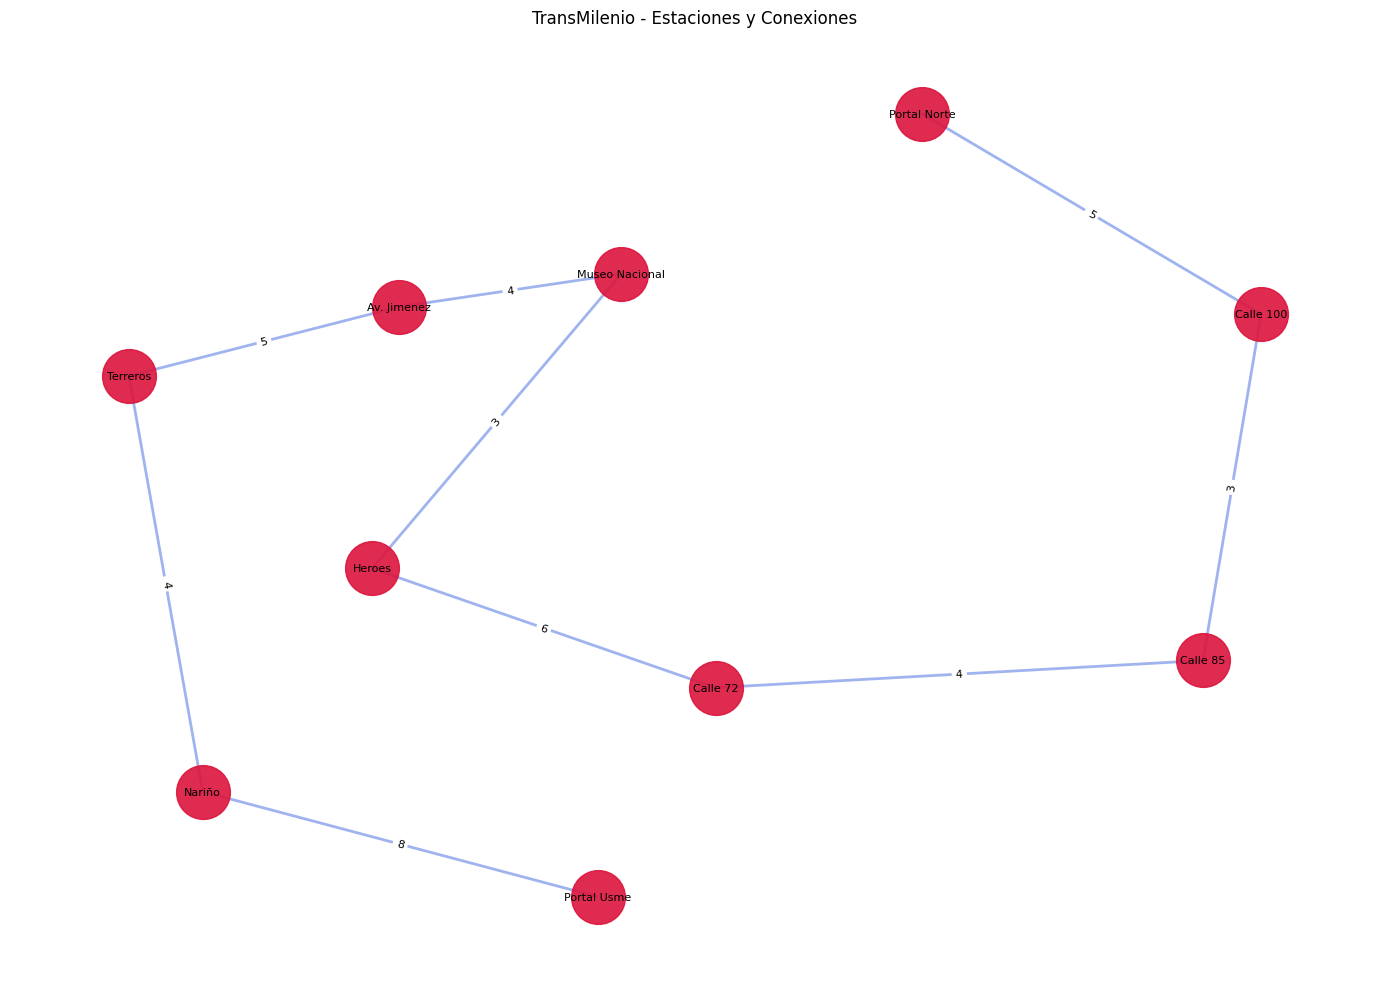

In [20]:
# Función para visualizar la red de estaciones de TransMilenio como un grafo
def visualizar_grafo_transmilenio():
    # Consulta en Neo4j todas las relaciones entre estaciones con su tiempo de conexión
    # WHERE id(e1) < id(e2)  # Evita duplicar relaciones bidireccionales
    resultado = con.query("""
    MATCH (e1:Estacion)-[r:CONECTA_CON]->(e2:Estacion)
    WHERE elementId(e1) < elementId(e2)
    RETURN e1.nombre as Origen, e2.nombre as Destino, r.tiempo_minutos as Tiempo
    """)

    # Crea un grafo no dirigido usando NetworkX
    G = nx.Graph()
    for record in resultado:
        G.add_edge(record['Origen'], record['Destino'], weight=record['Tiempo'])  # Agrega aristas con peso 'Tiempo'

    # ----- Visualización del grafo -----
    plt.figure(figsize=(14, 10))                     # Define el tamaño de la figura
    pos = nx.spring_layout(G, k=2, iterations=50)    # Calcula posiciones de los nodos (algoritmo de resorte)

    nx.draw_networkx_nodes(G, pos, node_color='#DC143C', node_size=1500, alpha=0.9)  # Dibuja nodos
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')           # Etiquetas de nodos
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='#4169E1')         # Dibuja las aristas
    edge_labels = nx.get_edge_attributes(G, 'weight')                                # Obtiene los pesos (tiempos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)       # Muestra los pesos en el grafo

    plt.title("TransMilenio - Estaciones y Conexiones")  # Título del gráfico
    plt.axis('off')                                      # Oculta los ejes
    plt.tight_layout()                                   # Ajusta el diseño
    plt.show()                                           # Muestra el grafo en pantalla

# Llama a la función para visualizar el grafo
visualizar_grafo_transmilenio()

## **Ejercicio 2: Red doméstica de vuelos (en Colombia)**

In [21]:
# Elimina todos los nodos con las etiquetas 'Aeropuerto' o 'Aerolinea' junto con sus relaciones
con.execute("""
MATCH (n)
WHERE n:Aeropuerto OR n:Aerolinea
DETACH DELETE n
""")

###**Crear los nodos (aeropuertos)**

In [22]:
# Crea una lista de diccionarios con la información de los aeropuertos colombianos
aeropuertos = [
    {"codigo": "BOG", "ciudad": "Bogotá", "nombre": "El Dorado", "region": "Andina"},
    {"codigo": "MDE", "ciudad": "Medellín", "nombre": "José María Córdova", "region": "Andina"},
    {"codigo": "CLO", "ciudad": "Cali", "nombre": "Alfonso Bonilla Aragón", "region": "Pacífica"},
    {"codigo": "BAQ", "ciudad": "Barranquilla", "nombre": "Ernesto Cortissoz", "region": "Caribe"},
    {"codigo": "CTG", "ciudad": "Cartagena", "nombre": "Rafael Núñez", "region": "Caribe"},
    {"codigo": "SMR", "ciudad": "Santa Marta", "nombre": "Simón Bolívar", "region": "Caribe"},
    {"codigo": "PEI", "ciudad": "Pereira", "nombre": "Matecaña", "region": "Andina"},
    {"codigo": "BGA", "ciudad": "Bucaramanga", "nombre": "Palonegro", "region": "Andina"},
    {"codigo": "CUC", "ciudad": "Cúcuta", "nombre": "Camilo Daza", "region": "Andina"}
]

# Recorre la lista y crea un nodo 'Aeropuerto' en Neo4j por cada registro
for aero in aeropuertos:
    con.execute("""
    CREATE (a:Aeropuerto {codigo: $codigo, ciudad: $ciudad,
                          nombre: $nombre, region: $region})
    """, aero)

# Muestra en consola la cantidad total de aeropuertos creados
print(f"Se crearon {len(aeropuertos)} aeropuertos")

Se crearon 9 aeropuertos


###**Creación de relaciones**

In [23]:
# Crea las relaciones de vuelos directos entre aeropuertos, con duración y frecuencia semanal
vuelos = [
    ("BOG", "MDE", 55, 45),  # duración en minutos, frecuencia semanal
    ("BOG", "CLO", 60, 35),
    ("BOG", "BAQ", 90, 30),
    ("BOG", "CTG", 85, 28),
    ("BOG", "PEI", 50, 25),
    ("BOG", "BGA", 45, 20),
    ("BOG", "CUC", 70, 18),
    ("MDE", "CLO", 55, 20),
    ("MDE", "CTG", 75, 15),
    ("MDE", "PEI", 40, 12),
    ("CLO", "CTG", 80, 10),
    ("BAQ", "CTG", 30, 25),
    ("BAQ", "SMR", 40, 20),
    ("CTG", "SMR", 35, 15),
    ("MDE", "BAQ", 80, 12)
]

# Recorre cada vuelo y crea dos relaciones (ida y vuelta) entre los aeropuertos correspondientes
for origen, destino, duracion, frecuencia in vuelos:
    con.execute("""
    MATCH (a1:Aeropuerto {codigo: $origen})
    MATCH (a2:Aeropuerto {codigo: $destino})
    CREATE (a1)-[:VUELO_DIRECTO {duracion_min: $duracion, frecuencia_semanal: $frecuencia}]->(a2)
    CREATE (a2)-[:VUELO_DIRECTO {duracion_min: $duracion, frecuencia_semanal: $frecuencia}]->(a1)
    """, {"origen": origen, "destino": destino, "duracion": duracion, "frecuencia": frecuencia})

# Muestra cuántas rutas bidireccionales de vuelo se crearon
print(f"Se crearon {len(vuelos)} vuelos bidireccionales")

Se crearon 15 vuelos bidireccionales


###**Consultas**


In [24]:
# Calcula la ruta más rápida entre dos aeropuertos usando la menor duración total de vuelo
# (en este caso, entre BGA - Bucaramanga y SMR - Santa Marta)
resultado = con.query("""
MATCH path = shortestPath(
    (inicio:Aeropuerto {codigo: 'BGA'})-[:VUELO_DIRECTO*]-(fin:Aeropuerto {codigo: 'SMR'})
)
WITH path,
[r in relationships(path) | r.duracion_min] as duracion_min,
[n in nodes(path) | n.ciudad] as ciudades
RETURN ciudades as Ruta,
       reduce(total=0, x in duracion_min | total + x) as Duracion_total,
       length(path) as Escalas
""")

# Muestra en consola la ruta, la duración total y el número de escalas
for record in resultado:
    print(f"Ruta: {record['Ruta']}")
    print(f"Duración total: {record['Duracion_total']}")
    print(f"Escalas: {record['Escalas']}")

Ruta: ['Bucaramanga', 'Bogotá', 'Barranquilla', 'Santa Marta']
Duración total: 175
Escalas: 3


###**Visualización de los grafos**

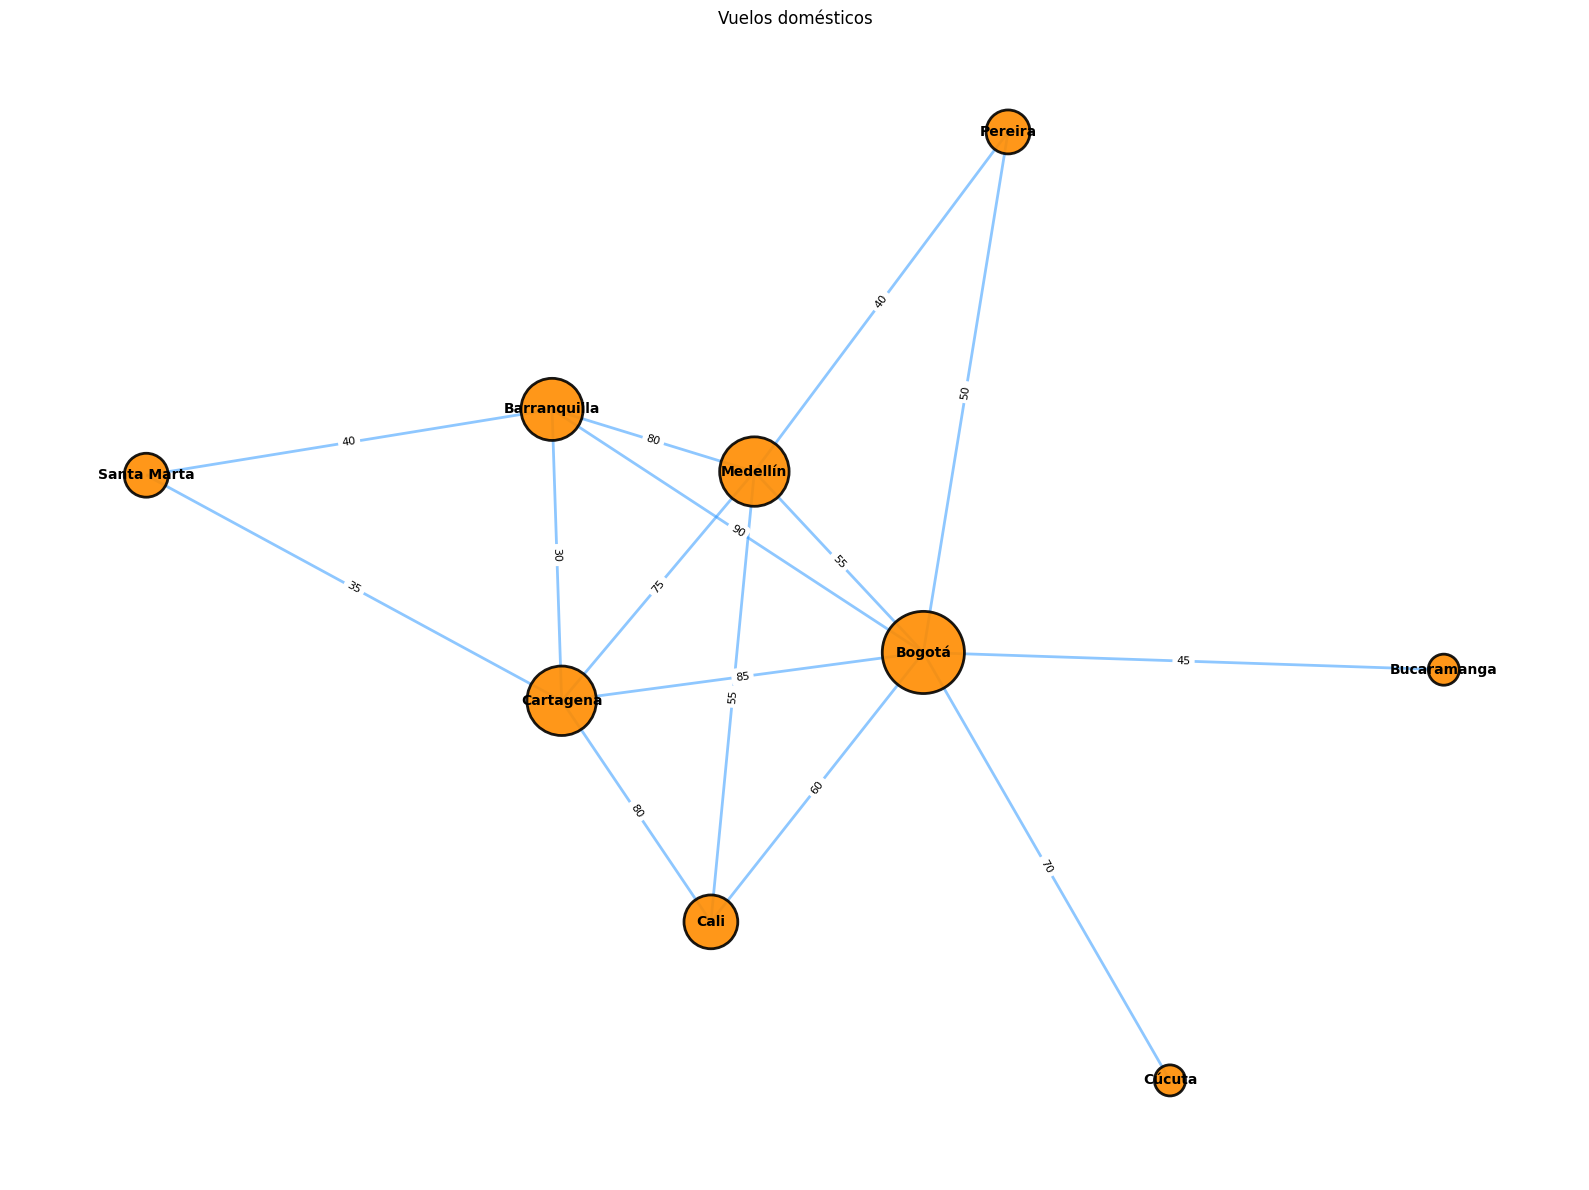

In [25]:
# Consulta en Neo4j todas las relaciones de vuelos directos entre aeropuertos con su duración y frecuencia
resultado = con.query("""
MATCH (a1:Aeropuerto)-[r:VUELO_DIRECTO]->(a2:Aeropuerto)
WHERE elementId(a1) < elementId(a2)
RETURN a1.codigo as origen, a1.ciudad as ciudad_origen,
       a2.codigo as destino, a2.ciudad as ciudad_destino,
       r.duracion_min as duracion, r.frecuencia_semanal as frecuencia
""")

# Crea un grafo no dirigido con NetworkX para representar los vuelos entre ciudades
G = nx.Graph()
for record in resultado:
    G.add_edge(record['ciudad_origen'], record['ciudad_destino'],
               weight=record['duracion'], frecuencia=record['frecuencia'])

# ----- Código para visualizar el grafo -----
plt.figure(figsize=(16, 12))                                  # Define el tamaño del gráfico
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)         # Calcula posiciones de los nodos

# Ajusta el tamaño de cada nodo según su conectividad (grado)
node_sizes = [G.degree(node) * 500 for node in G.nodes()]

# Dibuja los nodos del grafo con color y borde
nx.draw_networkx_nodes(G, pos, node_color='#FF8C00',
                       node_size=node_sizes, alpha=0.9,
                       edgecolors='black', linewidths=2)

# Dibuja etiquetas de los nodos (ciudades)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Dibuja las aristas (vuelos directos)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='#1E90FF')

# Muestra las etiquetas de las aristas con la duración del vuelo
edge_labels = {(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

# Personalización del gráfico
plt.title("Vuelos domésticos")  # Título del grafo
plt.axis('off')                  # Oculta los ejes
plt.tight_layout()               # Ajusta el diseño
plt.show()                       # Muestra la visualización